<a href="https://colab.research.google.com/github/economicactivist/DS-Unit-2-Applied-Modeling/blob/master/module1-define-ml-problems/LS_DS_231_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Is your problem regression or classification?
- [ ] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- [ ] Choose your evaluation metric(s).
    - Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
    - Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?
- [ ] Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

If you haven't found a dataset yet, do that today. [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2) and choose your dataset.

Some students worry, ***what if my model isn't “good”?*** Then, [produce a detailed tribute to your wrongness. That is science!](https://twitter.com/nathanwpyle/status/1176860147223867393)

------------------

###Schema diagram for csv files

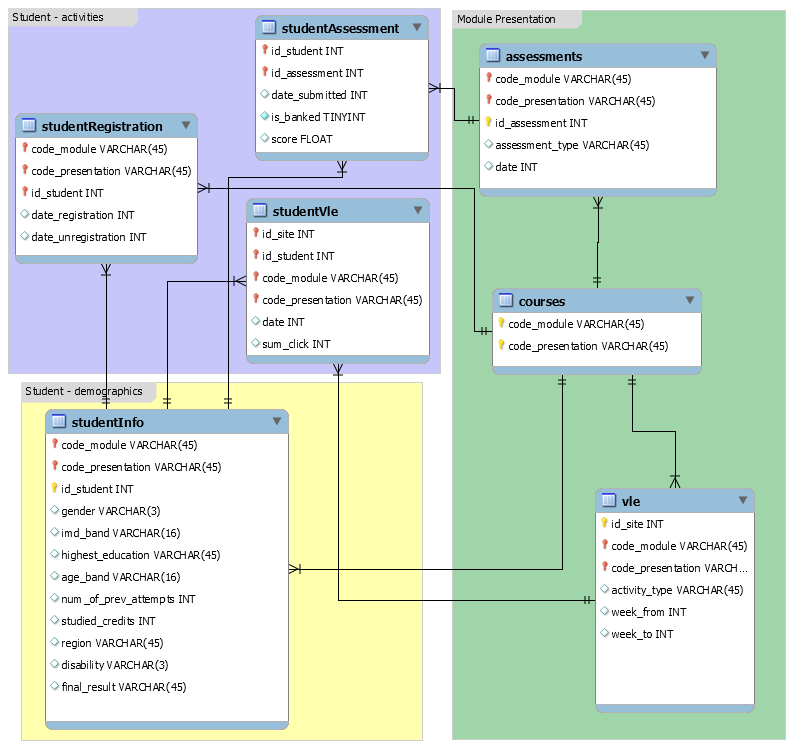

In [14]:
from IPython.display import Image, display
display(Image(filename='/content/drive/My Drive/Datasets/Images/schema_diagram.png'))

<h3>My chosen dataset has different csv files that describe different aspects of the student and their interacations with the LMS.  The LMS is referred to as a VLE (virtual learning envrionment)in the dataset</h3>

A chief goal of learning analytics is to assess academic performance, so there <b>two</b> variables that would be of interest:  

1. "final_result": a categorical variable in the StudentInfo csv and
2. "score" a continuous variable in the studentAssessment csv

I've decided to choose "final_result" as my target variable because, as the name implies, it represents values that account for students overall performance in an academic period.  The "score" variable, on the other hand, only has values that represent performance on different assessments within an academic period.  Because different assessments have different weights, interpreting the meaning of scores with reference to other data would be more complicated. 


Personal Notes: 
B - February
J - October

The imd_band variable relates to the Index of Multiple deprevation, which is the UK government's way of measuring <a href = "https://www.arcgis.com/apps/Cascade/index.html?appid=3c16c360b5704192a550f844b13ffb0a"> how deprived different neighborhoods are</a>, compared to one another. 


In [0]:
import pandas as pd
import numpy as np

In [0]:
#!pip install category_encoders==2.*

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix, classification_report
import xgboost as xgb
#!pip install category_encoders==2.*
#OneHotEncoder(use_cat_names=True)


In [13]:
pd.read_csv('/content/drive/My Drive/Datasets/Build_2/studentInfo.csv')

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass
...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail
32589,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction
32590,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass
32591,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn


In [0]:
grades = pd.read_csv('/content/drive/My Drive/Datasets/Build_2/studentInfo.csv')

In [16]:
grades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 12 columns):
code_module             32593 non-null object
code_presentation       32593 non-null object
id_student              32593 non-null int64
gender                  32593 non-null object
region                  32593 non-null object
highest_education       32593 non-null object
imd_band                31482 non-null object
age_band                32593 non-null object
num_of_prev_attempts    32593 non-null int64
studied_credits         32593 non-null int64
disability              32593 non-null object
final_result            32593 non-null object
dtypes: int64(3), object(9)
memory usage: 3.0+ MB


In [0]:
#check each column for data entry errors

In [0]:
def num_unique(df):
  """function for checking the categorical
  values in all columns"""
  a = []
  for col in df:
    if df[col].dtype.name != 'int64':
      a.append(df[col].unique())
  return a


In [76]:
num_unique(grades)

[array(['AAA', 'BBB', 'CCC', 'DDD', 'EEE', 'FFF', 'GGG'], dtype=object),
 array(['2013J', '2014J', '2013B', '2014B'], dtype=object),
 array(['M', 'F'], dtype=object),
 array(['East Anglian Region', 'Scotland', 'North Western Region',
        'South East Region', 'West Midlands Region', 'Wales',
        'North Region', 'South Region', 'Ireland', 'South West Region',
        'East Midlands Region', 'Yorkshire Region', 'London Region'],
       dtype=object),
 array(['HE Qualification', 'A Level or Equivalent', 'Lower Than A Level',
        'Post Graduate Qualification', 'No Formal quals'], dtype=object),
 array(['90-100%', '20-30%', '30-40%', '50-60%', '80-90%', '70-80%', nan,
        '60-70%', '40-50%', '10-20', '0-10%'], dtype=object),
 array(['55<=', '35-55', '0-35'], dtype=object),
 array(['N', 'Y'], dtype=object),
 array(['Pass', 'Withdrawn', 'Fail', 'Distinction'], dtype=object)]

###There don't appear to be any major issues with data entry. Some minor notes
 - The percent sign is missing from one category of imd_band
 - '55<=' in 'age_band' is ambiguous.  I think prob should be >=55.  Also the borders of the age ranges are not clearly defined.  For example, a person who is 35 years old could belong to either the '0-35' or the '35-55' categories without better clarity.  Still I think this overlap minor given the size of each age range. 

In [77]:
grades.final_result.value_counts(normalize=True)  #baselines for prediction

Pass           0.379253
Withdrawn      0.311601
Fail           0.216365
Distinction    0.092781
Name: final_result, dtype: float64

<h2>References</h2>

<p>Kuzilek J., Hlosta M., Zdrahal Z. Open University Learning Analytics dataset Sci. Data 4:170171 doi: 10.1038/sdata.2017.171 (2017).</p>